In [59]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    explained_variance_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess


def return_regr_score(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    evs = explained_variance_score(y_true, y_pred)
    Scores = namedtuple("Scores", ["mse", "mae", "rmse", "r2", "evs"])
    return Scores(mse, mae, rmse, r2, evs)


# Function to generate and plot time series, ACF, and PACF
def plot_series_with_acf_pacf(series, title):
    fig, axes = plt.subplots(1, 3, figsize=(15, 3))

    axes[0].plot(series, label="Time Series")
    axes[0].set_title(f"{title} - Time Series")
    # axes[0].legend()
    plot_acf(series, lags=20, ax=axes[1], title="ACF")
    plot_pacf(series, lags=20, ax=axes[2], title="PACF")
    plt.tight_layout()
    plt.show()


def arima_forecast(train_series, predicted_series, p, d, q):
    """
    Forecasts a time series one timestep at a time using an ARIMA model.

    Parameters:
        train_series (pd.Series or np.array): The time series data for training.
        predicted_series (pd.Series or np.array): The actual series to compare the predictions.
        p (int): The order of the AR component.
        d (int): The order of differencing.
        q (int): The order of the MA component.

    Returns:
        np.array: The forecasted values.
    """
    train_series = np.array(train_series).copy()
    predicted_series = np.array(predicted_series).copy()
    steps = len(predicted_series)
    prediction = np.zeros(steps)

    # Forecast one timestep at a time
    for step in range(steps):
        # Fit the ARIMA model to the current data
        model = ARIMA(train_series, order=(p, d, q))
        model_fitted = model.fit()

        # Predict the next value and store it in prediction
        predicted_next_value = model_fitted.forecast(steps=1)
        prediction[step] = predicted_next_value[0]

        # Append the actual value to the train_series
        actual_next_value = np.array([predicted_series[step]])
        train_series = np.concatenate((train_series, actual_next_value))

    # Return only the forecasted values
    return prediction

# Load Data

In [60]:
path = "input/delhi-climate/DailyDelhiClimateTrain.csv"
df = pd.read_csv(path)
print(df.shape)
df.head() 

(1462, 5)


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [61]:
x = df.set_index(pd.to_datetime(df["date"]))["meantemp"].to_frame()
x_bounded = x.loc[x.index < "2013-04-01"]

n_train = round(x_bounded.shape[0] * 0.87)
x_train = x_bounded[:n_train].values.flatten()
x_test = x_bounded[n_train:].values.flatten()

print(x_train.shape, x_test.shape)

(78,) (12,)


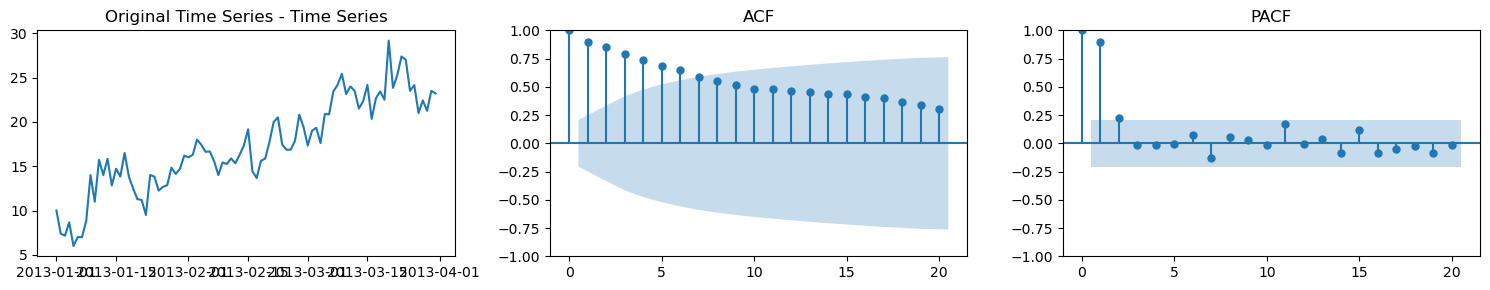

In [62]:
plot_series_with_acf_pacf(x_bounded, "Original Time Series")

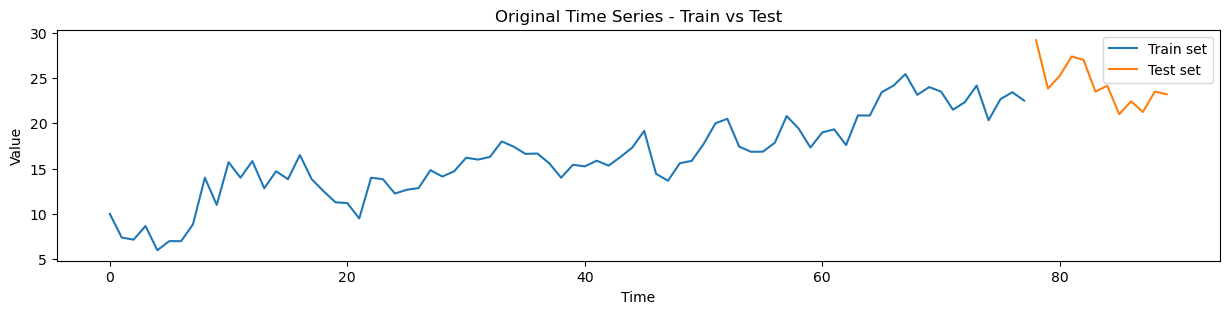

In [63]:
ax = plt.figure(figsize=(15, 3))
plt.plot(range(0, n_train), x_train, label="Train set")
plt.plot(range(n_train, n_train + len(x_test)), x_test, label="Test set")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Original Time Series - Train vs Test")
plt.legend()
plt.show()

### Step 1: Check for stationarity

In [64]:
from statsmodels.tsa.stattools import adfuller

# H0: a unit root is present (not stationary) 
# Ha: a unit root is not present (stationary)

result = adfuller(x_train)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -1.6880644265746496
p-value: 0.43727229764000025


Here the p-value > 0.05, meaning that we can not reject \(H_0\) (the series has a unit root). Therefore, the series is not stationary.

After this, we do differencing and check if the series is stationary.

In [65]:
x_train_diff_1 = np.diff(x_train)
result = adfuller(x_train_diff_1)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -4.471970125375864
p-value: 0.00022088918116437378


Here the p-value <> 0.05, meaning that we can reject \(H_0\) (the series has a unit root). Therefore, the series is stationary after 1 differencing.

### Step 2: Identify model parameters

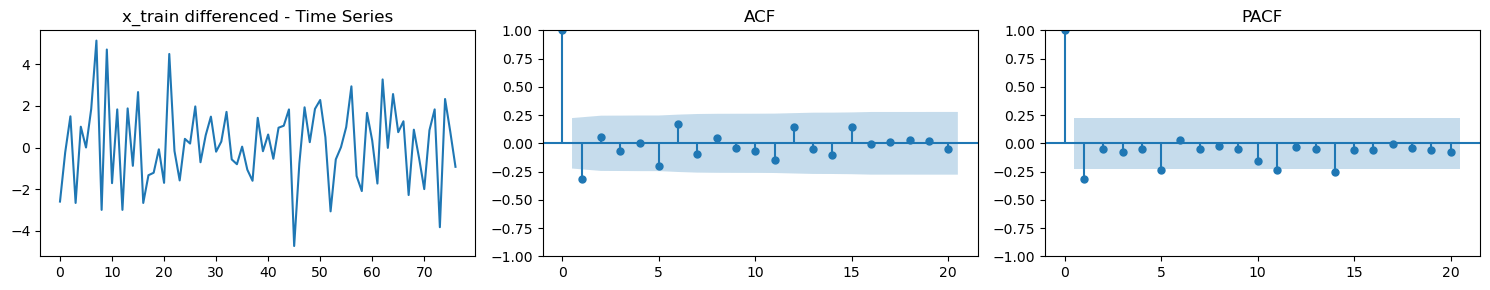

In [66]:
plot_series_with_acf_pacf(x_train_diff_1, "x_train differenced")

From the ACF and PACF:

- p=1: Based on the significant spike at lag 1 in the PACF.
- q=1: Based on the significant spike at lag 1 in the ACF.

### Step 3: Forecasting

In [67]:
forecast = arima_forecast(
    train_series=x_train, predicted_series=x_test, p=1, d=1, q=1
)

score = return_regr_score(x_test, forecast)

print("ARIMA model:", score)

ARIMA model: Scores(mse=7.125451155379444, mae=1.9954978885604555, rmse=2.6693540708155306, r2=-0.261893603779338, evs=-0.2618840141499048)


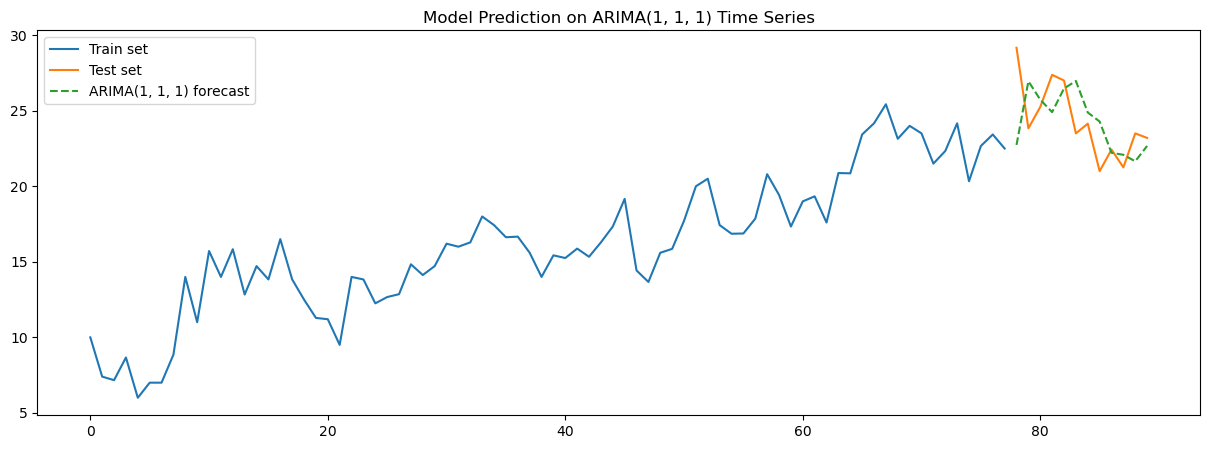

In [68]:
ax = plt.figure(figsize=(15, 5))
plt.plot(range(0, len(x_train)), x_train, label="Train set")
plt.plot(range(len(x_train), len(x_train) + len(x_test)), x_test, label="Test set")
plt.plot(range(len(x_train), len(x_train) + len(x_test)), forecast, label="ARIMA(1, 1, 1) forecast", linestyle="--")
plt.title("Model Prediction on ARIMA(1, 1, 1) Time Series")
plt.legend()
plt.show()